In [1]:
cd /home

/home


In [31]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.models.astromer_1 import get_ASTROMER
from src.utils import get_metrics
from matplotlib import gridspec
from src.data import get_loader
from src.data.zero import pretraining_pipeline
from sklearn.feature_selection import r_regression
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
folder = './presentation/results/lfgr/'
# folder = './presentation/experiments/astromer_0/results/bugstromer/2023-10-16_14-06-03/'
exp_folders = glob.glob(os.path.join(folder, '*','pretraining'))
exp_folders = exp_folders[:-1] 

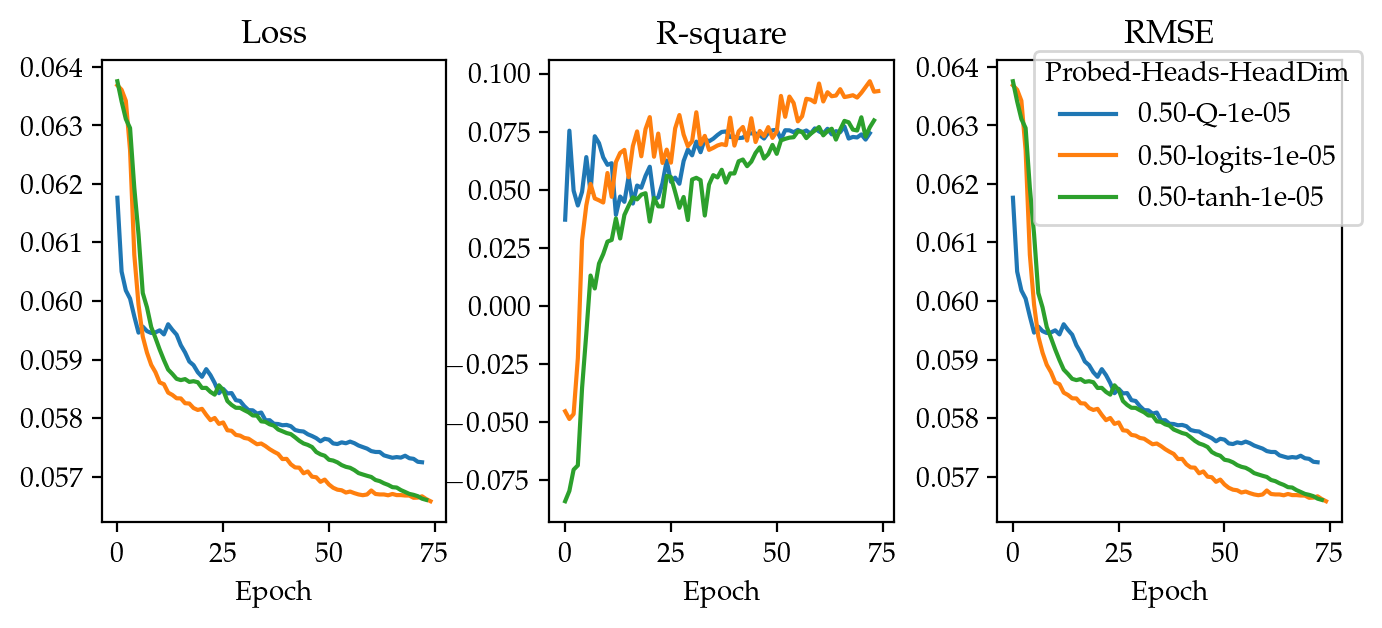

In [82]:
metric_names= ['epoch_loss', 'epoch_r_square', 'epoch_rmse']
format_metric_name = {
    'epoch_loss': 'Loss', 
    'epoch_r_square': "R-square", 
    'epoch_rmse': "RMSE"
}

rows = []
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200,
                         gridspec_kw={'hspace': 0., 'wspace': 0.3}, sharex=True)
axes = axes.flatten()
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'tensorboard')
    with open(config_path, 'r') as f:
        config = toml.load(f)
        val_metrics = get_metrics(os.path.join(log_dir, 'validation'), 
                                  metric_name='epoch_loss')
        best_epoch = val_metrics['value'].astype(float).argmin() 


        for index, metric in enumerate(metric_names):
            try:
                train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
                valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)

#                 axes[index].plot(train_metrics['step'], train_metrics['value'], label='Training')
                axes[index].plot(valid_metrics['step'], valid_metrics['value'], label='{:.2f}-{}-{}'.format(
                                                                                        config['probed'],
                                                                                        config['mask_format'],
                                                                                        config['lr'])) 
                
#                 axes[index].set_yscale('log')
#                 axes[index].set_xscale('log')
                
#                 print()
                axes[index].set_title(format_metric_name[metric])
                axes[index].set_xlabel('Epoch')
#                 axes[index].set_title(metric)
            
                config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
                config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)    
                
            except Exception as e:
                print(e)
                continue
                
        rows.append(pd.Series(config))
axes[-1].legend(bbox_to_anchor=(1.1, 1.05),
             title='Probed-Heads-HeadDim',  
             ncol=1,)
results = pd.concat(rows, axis=1).T

# Reconstruction

In [84]:
model_folder = './presentation/results/lfgr/2024-03-25_18-26-40/'

with open(os.path.join(model_folder, 'pretraining', 'config.toml'), 'r') as file:
    config = toml.load(file)
    
config

{'exp_name': 'lfgr',
 'data': './data/records/macho_clean/',
 'checkpoint': '-1',
 'gpu': '3',
 'debug': False,
 'scheduler': False,
 'arch': 'base',
 'num_layers': 2,
 'num_heads': 4,
 'head_dim': 64,
 'pe_dim': 256,
 'pe_base': 1000,
 'pe_exp': 2,
 'mixer': 128,
 'dropout': 0.0,
 'm_alpha': -1000000000.0,
 'mask_format': 'tanh',
 'use_leak': True,
 'repeat': 1,
 'lr': 1e-05,
 'bs': 1024,
 'patience': 20,
 'num_epochs': 10000,
 'window_size': 200,
 'probed': 0.5,
 'rs': 0.2,
 'same': 0.2,
 'nsp_prob': 0.5}

In [85]:
astromer = get_ASTROMER(num_layers=config['num_layers'],
                 num_heads=config['num_heads'],
                 head_dim=config['head_dim'],
                 mixer_size=config['mixer'],
                 dropout=config['dropout'],
                 pe_base=config['pe_base'],
                 pe_dim=config['pe_dim'],
                 pe_c=config['pe_exp'],
                 window_size=config['window_size'],
                 m_alpha=config['m_alpha'],
                 mask_format=config['mask_format'],
                 use_leak=config['use_leak'])

astromer.load_weights(os.path.join(model_folder, 'pretraining', 'weights'))

[INFO] No mask, Hyperbolic tanh! >:v
[INFO] No mask, Hyperbolic tanh! >:v


In [86]:
DATA = './data/records/macho_clean/test/'

test_loader = get_loader(DATA,
                         batch_size=16,
                          window_size=config['window_size'],
                          probed_frac=.5,
                          random_frac=0.,
                          same_frac=0.,
                          nsp_prob=config['nsp_prob'],
                          sampling=True,
                          shuffle=False,
                          cache=True,
                          normalize='zero-mean',
                          repeat=1,
                          aversion=config['arch'])

[INFO] Probed: 0.50 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking
[INFO] Cache activated


In [87]:
predictions = astromer.predict(test_loader.take(2))

[INFO] No mask, Hyperbolic tanh! >:v
[INFO] No mask, Hyperbolic tanh! >:v
2/2 [==============================] - 1s 77ms/step


2024-03-26 15:02:06.489856: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [88]:
predictions['magnitudes'].shape,predictions['reconstruction'].shape

((32, 200, 1), (32, 200, 1))

In [89]:
'{:.2f} - {:.2f}'.format(
    mean_squared_error(predictions['magnitudes'][..., 0], predictions['reconstruction'][..., 0], squared=True), 
    r2_score(predictions['magnitudes'][..., 0], predictions['reconstruction'][..., 0]))

'0.03 - 0.24'

Text(0.96, 0.5, 'Predicted Magnitude')

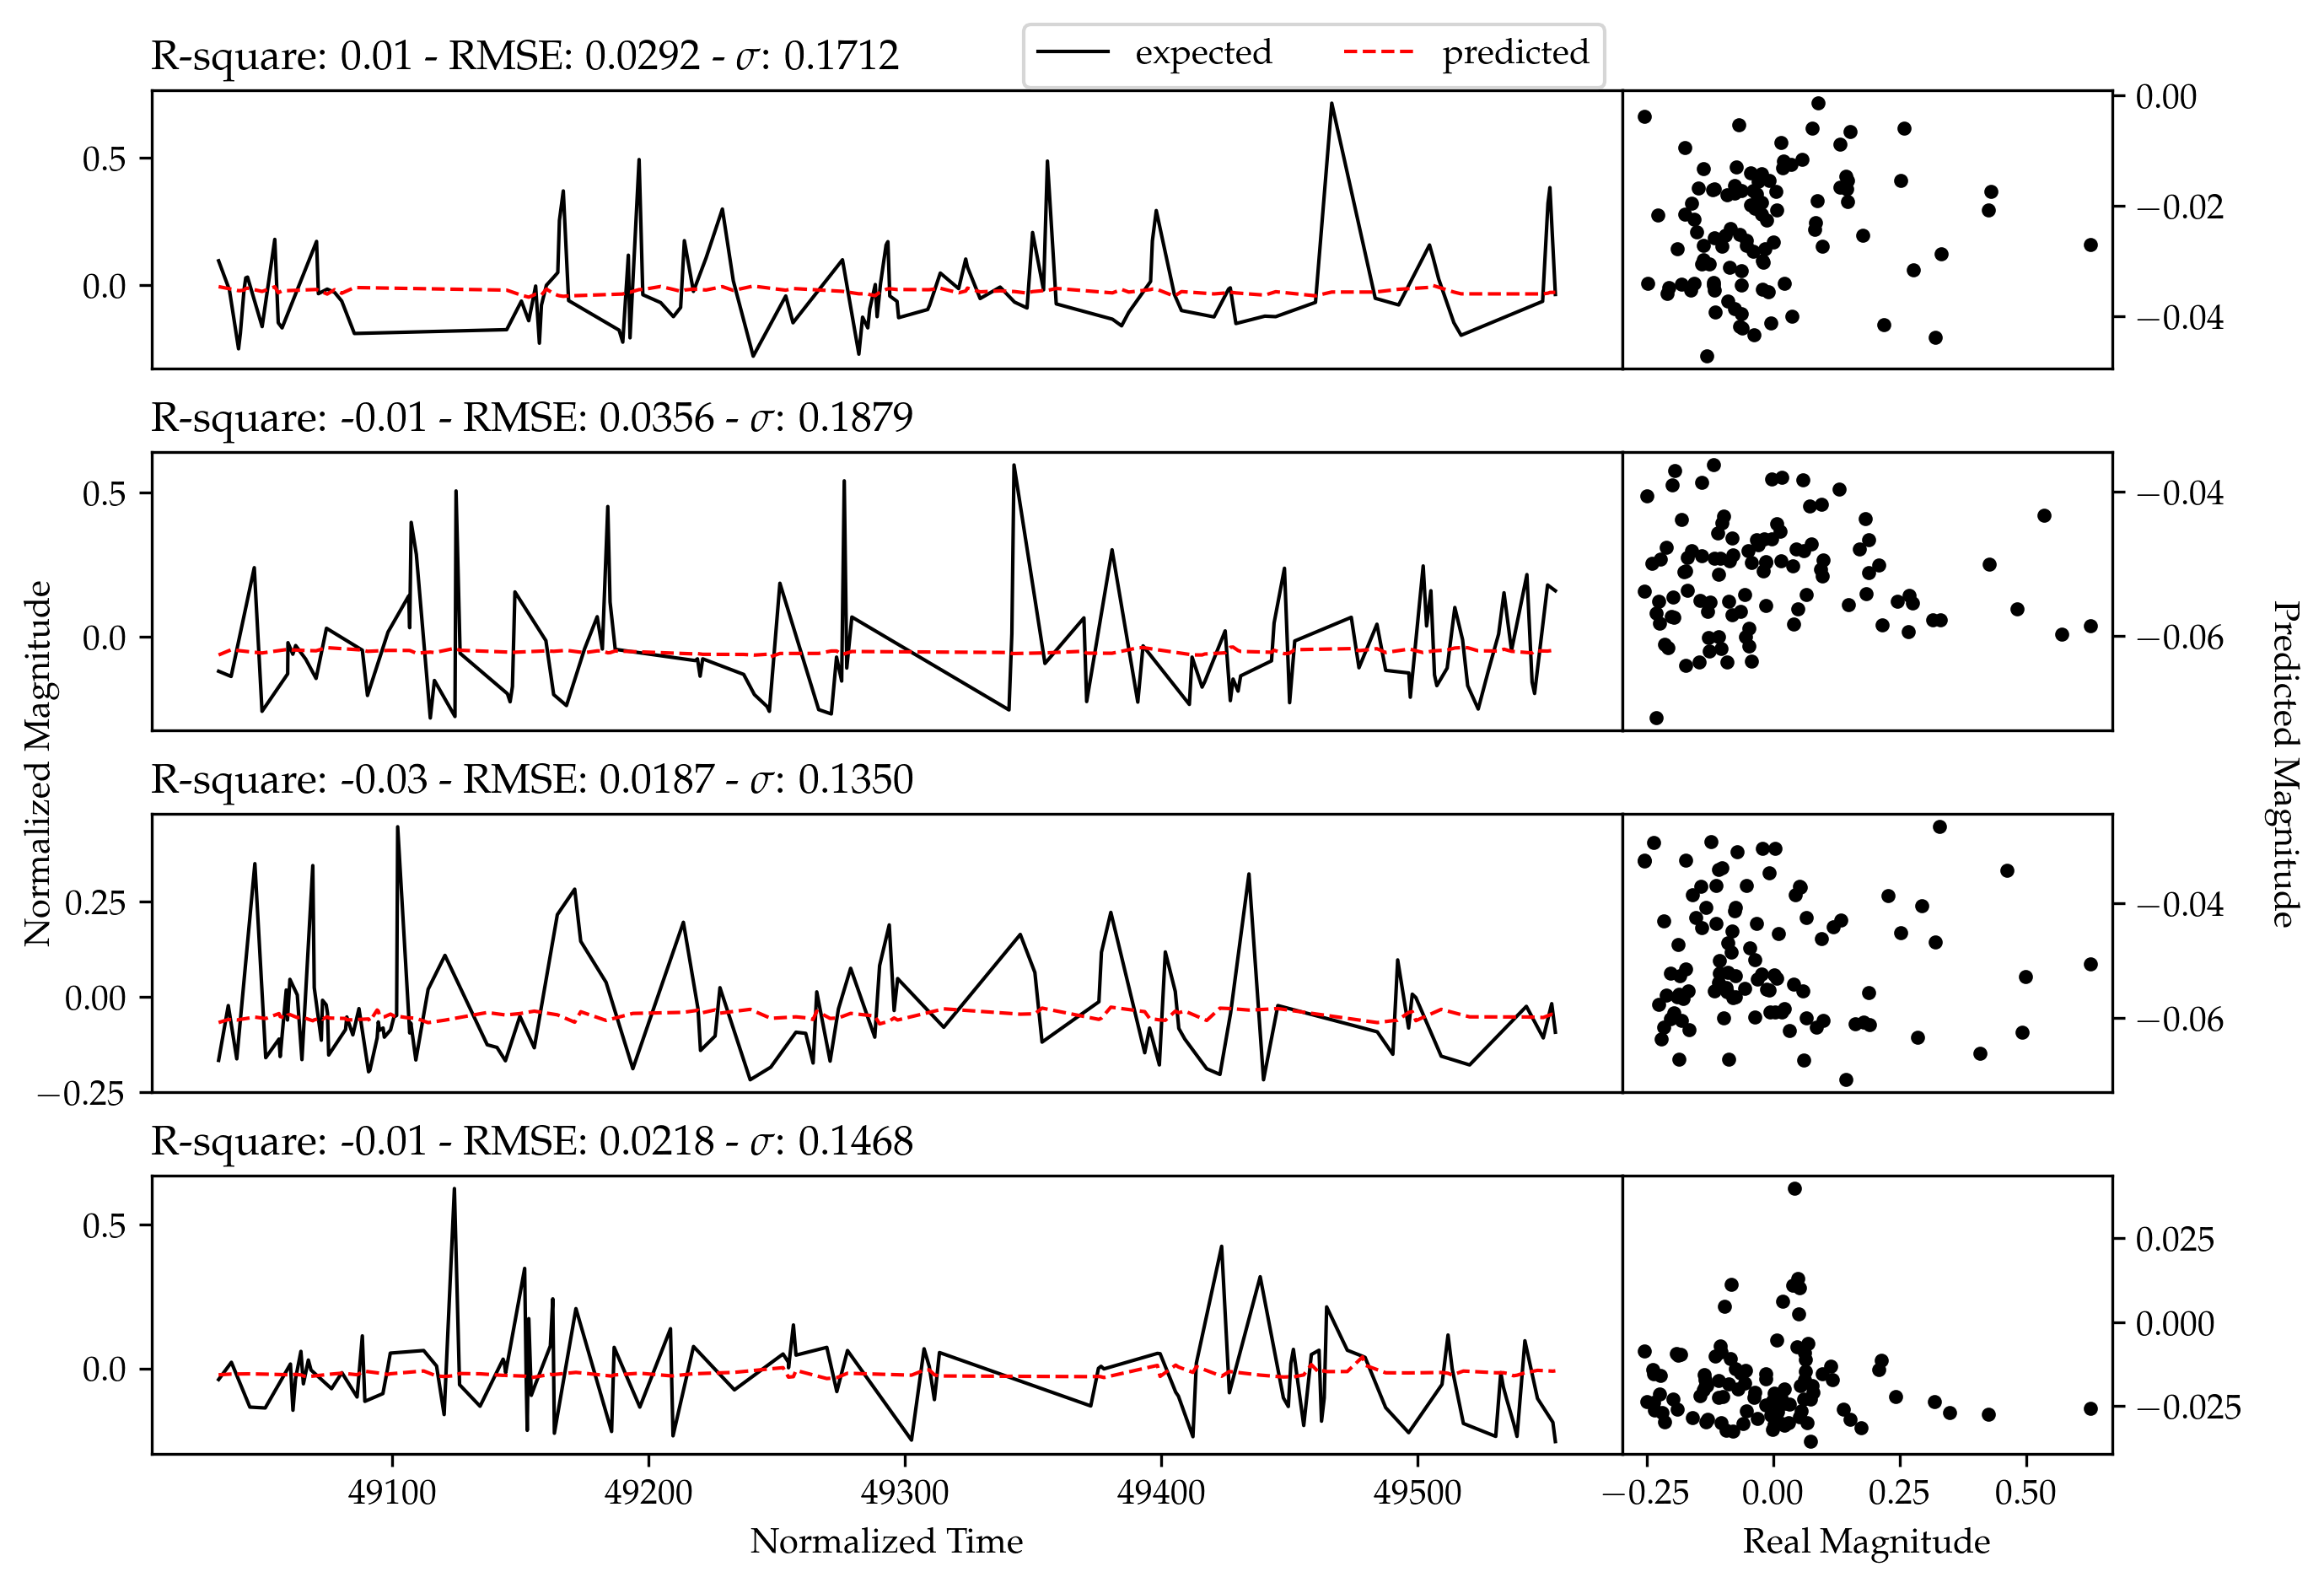

In [90]:
N = 4                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
gs.hspace = 0.3
gs.wspace = 0.
plt.subplots_adjust(hspace=0.2, wspace=0.05)

for i, x, y, m, t in zip(range(N), 
                      predictions['magnitudes'], 
                      predictions['reconstruction'], 
                      predictions['probed_mask'],
                      predictions['times']):
    
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])

    probed_true  = tf.boolean_mask(x[..., 0], m[..., 0])
    probed_pred  = tf.boolean_mask(y[..., 0], m[..., 0])
    sampling_times  = tf.boolean_mask(t[..., 0], m[..., 0])
    
    r2_val   = r2_score(probed_true, probed_pred)
    rmse_val = mean_squared_error(probed_true, probed_pred, squared=True)
    
    ax0.plot(sampling_times, probed_true, marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(sampling_times, probed_pred, marker='', linewidth=1, linestyle='--', color='r', label='predicted')
    ax1.plot(probed_true, probed_pred, '.', color='k')
    ax0.set_title('R-square: {:.2f} - RMSE: {:.4f} - $\sigma$: {:.4f}'.format(r2_val, 
                                                                          rmse_val, 
                                                                          tf.math.reduce_std(probed_true)), loc='left')
    
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 

    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.3))
        
ax0.set_xlabel('Normalized Time')

ax1.set_xlabel('Real Magnitude')
fig.text(0.075, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)

# normalized

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

Text(0.96, 0.5, 'Predicted Magnitude')

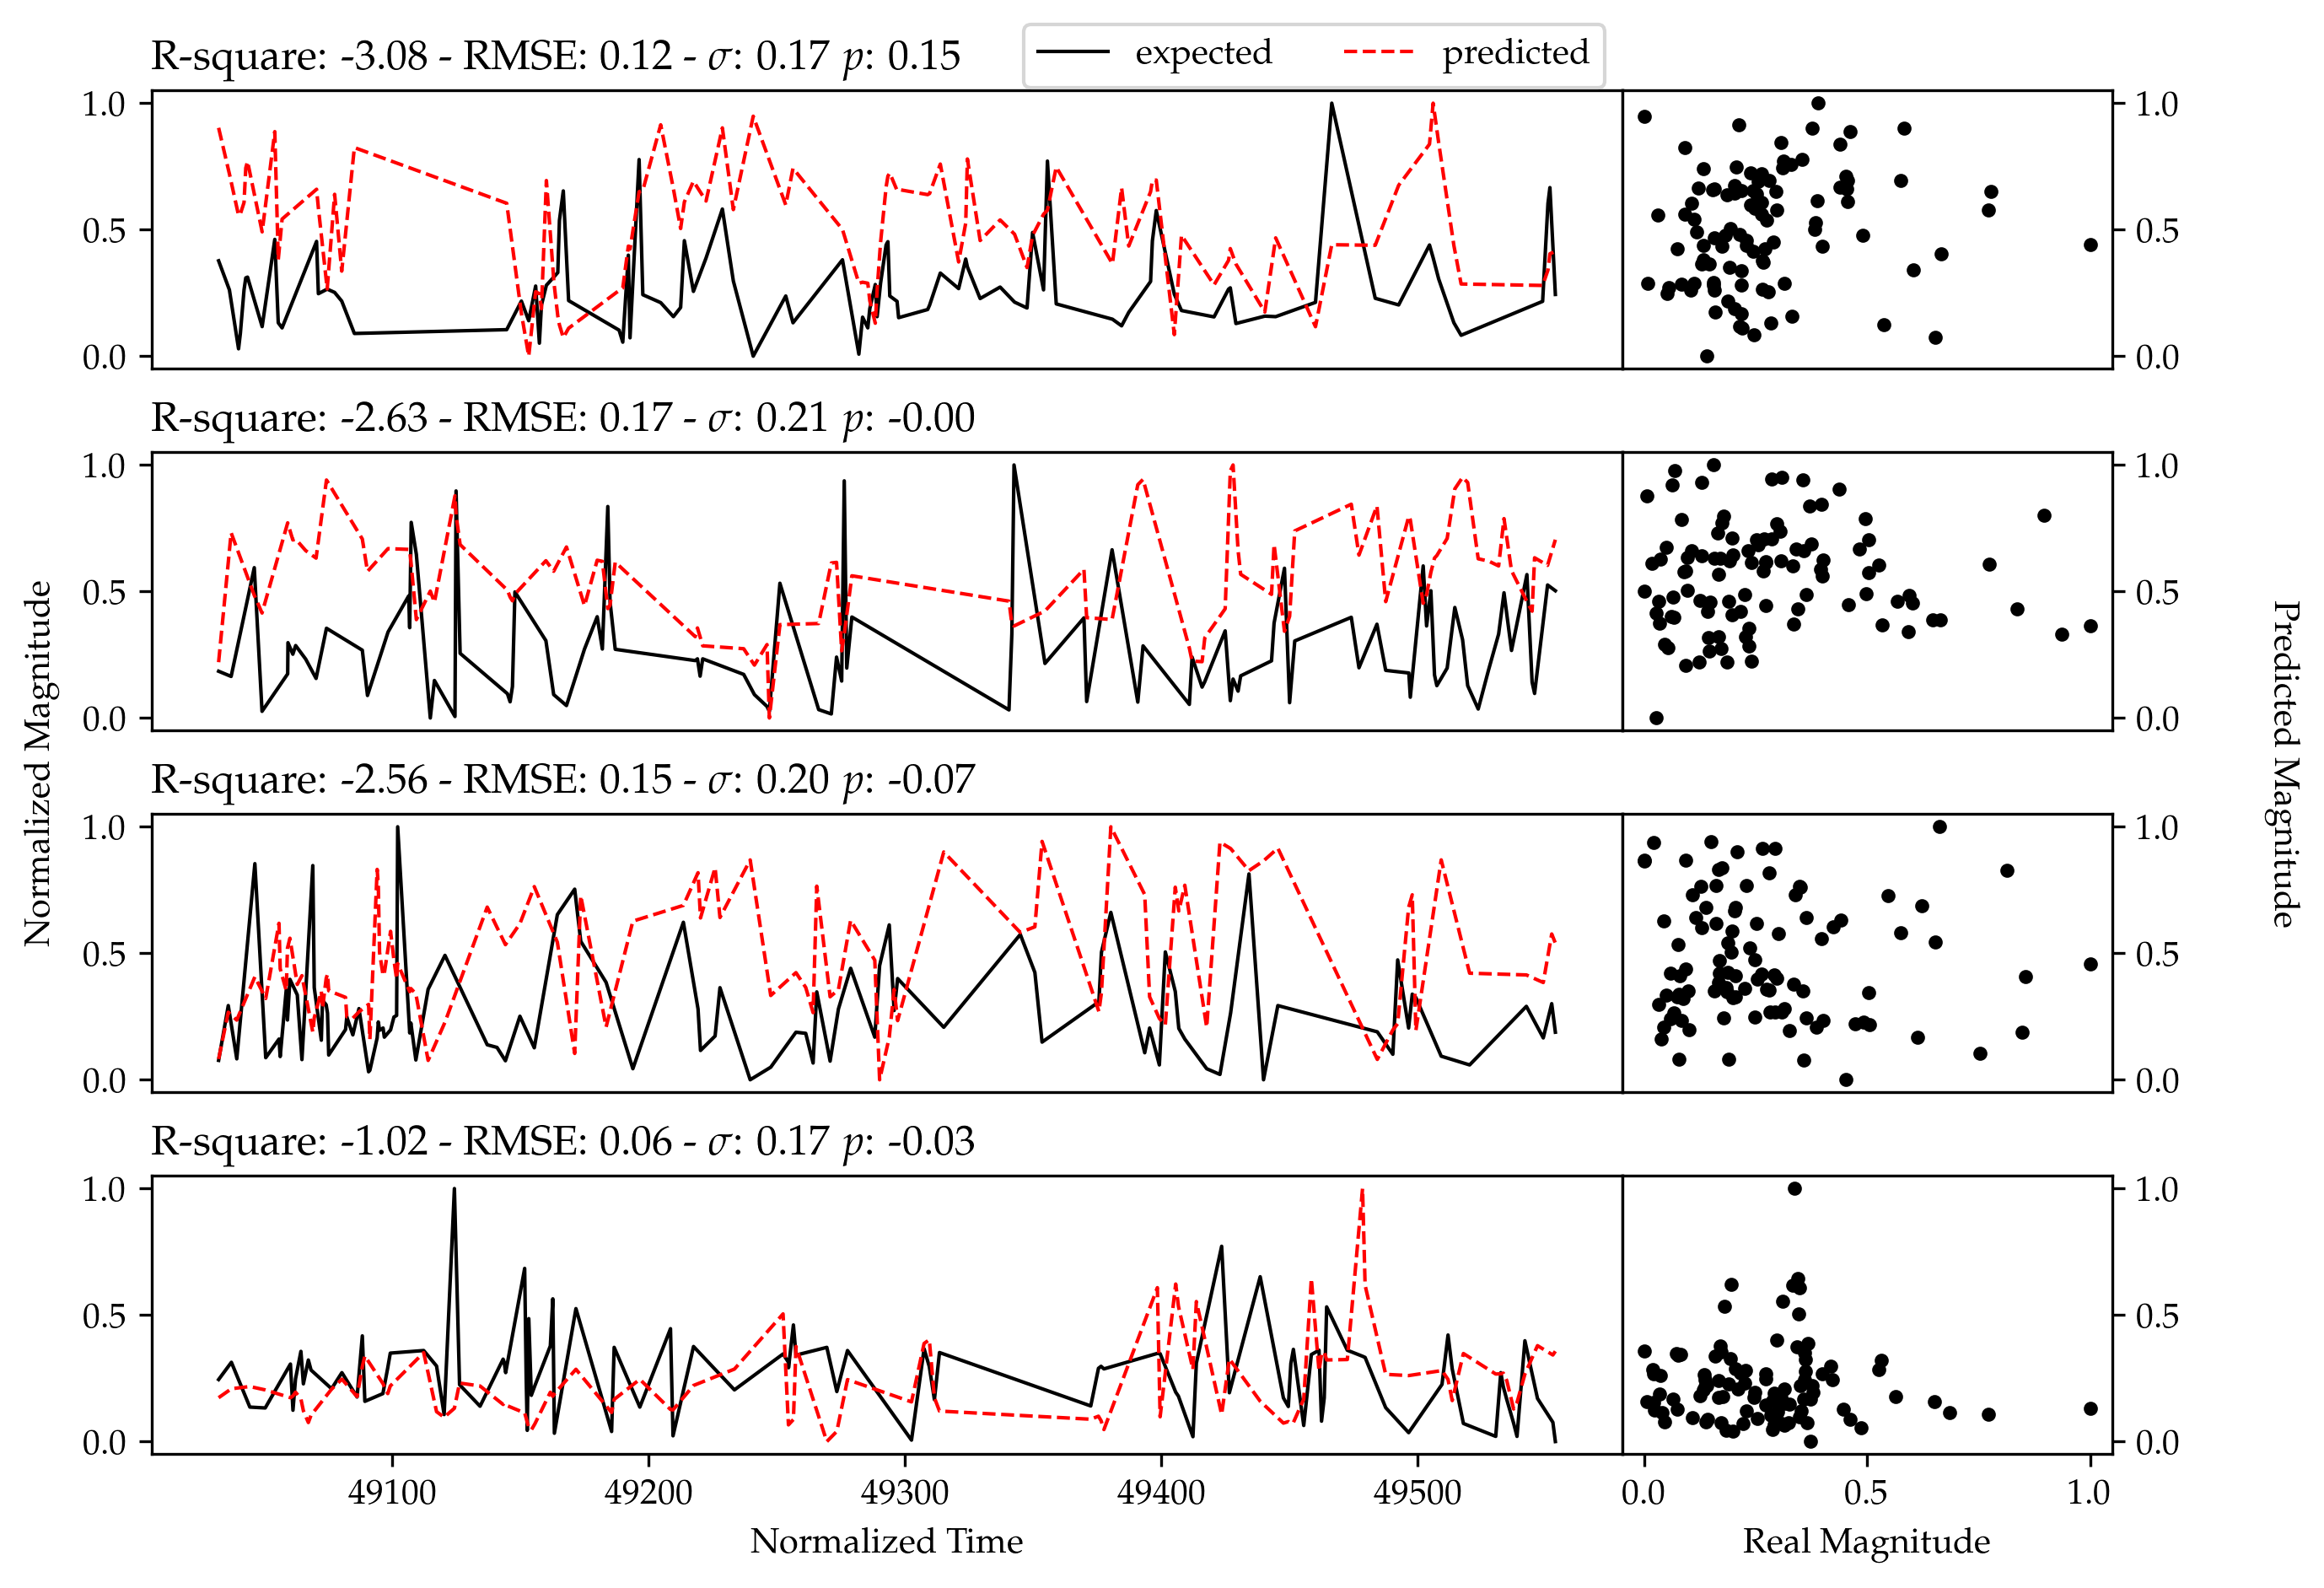

In [91]:
N = 4                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
gs.hspace = 0.3
gs.wspace = 0.
plt.subplots_adjust(hspace=0.2, wspace=0.05)

for i, x, y, m, t in zip(range(N), 
                      predictions['magnitudes'], 
                      predictions['reconstruction'], 
                      predictions['probed_mask'],
                      predictions['times']):
    
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])

    probed_true  = tf.boolean_mask(x[..., 0], m[..., 0])
    probed_pred  = tf.boolean_mask(y[..., 0], m[..., 0])
    sampling_times  = tf.boolean_mask(t[..., 0], m[..., 0])
        
    #Corrections
    probed_pred = (probed_pred - np.min(probed_pred))/(np.max(probed_pred) - np.min(probed_pred))  
    probed_true = (probed_true - np.min(probed_true))/(np.max(probed_true) - np.min(probed_true))
    
    p = r_regression(probed_true[:, None], probed_pred[:, None])    
    r2_val   = r2_score(probed_true, probed_pred)
    rmse_val = mean_squared_error(probed_true, probed_pred, squared=True)

    ax0.plot(sampling_times, probed_true, marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(sampling_times, probed_pred, marker='', linewidth=1, linestyle='--', color='r', label='predicted')
    ax1.plot(probed_true, probed_pred, '.', color='k')
    ax0.set_title('R-square: {:.2f} - RMSE: {:.2f} - $\sigma$: {:.2f} $p$: {:.2f}'.format(r2_val, 
                                                                          rmse_val, 
                                                                          tf.math.reduce_std(probed_true),
                                                                          p[0]), loc='left')
    
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 

    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.3))
        
ax0.set_xlabel('Normalized Time')

ax1.set_xlabel('Real Magnitude')
fig.text(0.075, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)